## Small Policy v1
Given 10x10 grid world, (s, a, r, sp) data, find optimal policy

Lisa Fung

Last Updated: 11/8/24

### Main functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
small_data = pd.read_csv("../data/small.csv")

In [3]:
# Timing function
import time
from functools import wraps

def time_it(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed_time = time.time() - start_time
        print(f"Function '{func.__name__}' executed in {elapsed_time:.6f} seconds")
        return result, elapsed_time
    return wrapper

In [4]:
n_states = 100
n_actions = 4

@time_it
def estimate_transitions():
    # Estimate T(sp | s, a) in transition matrix T(s, a, sp)
    T = np.zeros((n_states + 1, n_actions + 1, n_states + 1))

    # Find counts N(s, a, sp)
    grouped_T = small_data.set_index(['s', 'a', 'sp']).groupby(by=['s', 'a', 'sp']).count()
    for indices, row in grouped_T.iterrows():
        T[indices] = row.iloc[0]

    # Normalize along next state (sp) dimension to divide by N(s, a)
    T /= np.sum(T, axis=2, keepdims=True)
    T = np.nan_to_num(T, nan=0.0)   # convert nan to 0.0
    return T

T, time_T = estimate_transitions()

Function 'estimate_transitions' executed in 0.052860 seconds


C:\Users\lisaf\AppData\Local\Temp\ipykernel_2272\429732448.py:15: RuntimeWarning: invalid value encountered in divide
  T /= np.sum(T, axis=2, keepdims=True)


In [5]:
@time_it
def get_rewards():
    # Set rewards R(s, a) = R(s), only depends on current state
    R = np.zeros((n_states + 1))
    R[47] = 10
    R[82] = 3
    return R

R, time_R = get_rewards()

Function 'get_rewards' executed in 0.000000 seconds


In [6]:
# Value Iteration

def grid_display(x):
    # print(x[1:].reshape(10, 10))
    plt.matshow(x[1:].reshape(10, 10))
    plt.colorbar()
    plt.savefig("small_value_fct.png", dpi=300)

@time_it
def value_iteration(U, n_iters=100, discount=0.95, threshold=1e-3):
    # Update U with intermediate state updates instead of one iteration at a time
    for i in range(n_iters):
        residual = 0    # Maximum change in value among all U[s]
        for s in range(1, n_states+1):
            max_Us = 0
            for a in range(1, n_actions+1):
                later_rewards = sum([T[s, a, sp] * U[sp] for sp in range(1, n_states+1)])
                max_Us = max(max_Us, R[s] + discount * later_rewards)
            residual = max(residual, abs(U[s] - max_Us))
            U[s] = max_Us
        if residual < threshold:
            print(f"Value iteration converged within threshold {threshold} at iteration {i}\n")
            break
    return U


Value iteration converged within threshold 0.001 at iteration 89

Function 'value_iteration' executed in 1.297314 seconds


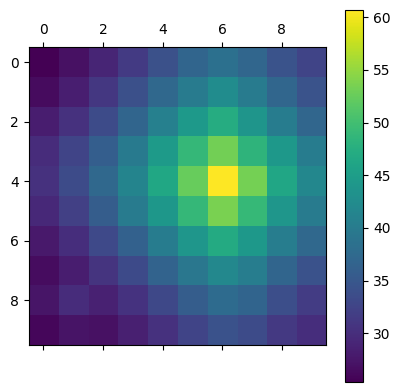

In [7]:
U = np.zeros(n_states + 1)  # Value function, U(s)
U_updated, time_valueiter = value_iteration(U, n_iters=100)
grid_display(U_updated)


In [8]:
# Extract optimal policy pi(s) = a from value function U(s)
@time_it
def extract_policy(U, discount=0.95):
    policy = np.zeros(n_states+1)
    for s in range(1, n_states+1):
        max_action = 0
        max_action_value = -float('inf')
        for a in range(1, n_actions+1):
            later_rewards = sum([T[s, a, sp] * U[sp] for sp in range(1, n_states+1)])
            curr_action_value = R[s] + discount * later_rewards
            if curr_action_value > max_action_value:
                max_action = a
                max_action_value = curr_action_value
        policy[s] = max_action

    return policy

best_policy, time_extractpolicy = extract_policy(U_updated)

Function 'extract_policy' executed in 0.013004 seconds


In [9]:
small_time = 0.070039 + 1.226796 + 0.013581
small_time

1.310416

### Data Exploration

In [10]:
# small_data.head()
# small_data.describe()
# small_data.hist()
# [print(col, small_data[col].value_counts()) for col in small_data.columns]

Small Data Information
- States s: [1, 100], all seen
- Actions a: [1, 4], all seen
    - 1: left, 2: right, 3: up, 4: down
- Rewards r: {0, 3, 10}
- Next states sp: [1, 100]

In [11]:
# Find R(s, a) > 0
small_data_pos_rewards = small_data[small_data['r'] > 0]    # Subset of small data with positive R(s, a)

# Find states, actions with positive rewards
# R(82, a) = 3
# R(47, a) = 10
small_data_pos_rewards[['s', 'a', 'r']].value_counts()

s   a  r 
82  2  3     154
    4  3     137
    3  3     135
47  1  10    128
    3  10    125
    2  10    113
    4  10    113
82  1  3     105
Name: count, dtype: int64

Optimal policy intuition: move toward 47, collect 82 along the way if possible
- $R(82, a) = 3$
- $R(47, a) = 10$
- $R(s, a) = 0$  $\forall s \neq 82, 47$

### Approach

1. Estimate transitions $T(s' | s, a)$ using **Maximum Likelihood Estimation** (Note: no exploration)
2. Set rewards $R(s, a)$ with $R(47, a) = 10$, $R(82, a) = 3$, all other $R(s, a) = 0$
3. Find optimal policy $\pi^*$ using **Value Iteration**

    a. Find $U^*(s)$ by updating $$U_{k+1}(s) = \max_a ( R(s,a) + \gamma * \sum_{s'} T(s' | s,a) \cdot U_k(s'))$$ until convergence when maximum change in value $||U_{k+1} - U_{k}||_{\infty} < \delta$

    b. Extract $\pi^*$ with $\pi^*(s) = \argmax_a ( R(s,a) + \gamma * \sum_{s'} T(s' | s,a) \cdot U^*(s') )$


In [12]:
n_states = 100
n_actions = 4

# Estimate T(sp | s, a) in transition matrix T(s, a, sp)
T = np.zeros((n_states + 1, n_actions + 1, n_states + 1))

# Find counts N(s, a, sp)
grouped_T = small_data.set_index(['s', 'a', 'sp']).groupby(by=['s', 'a', 'sp']).count()
for indices, row in grouped_T.iterrows():
    T[indices] = row.iloc[0]

# Normalize along next state (sp) dimension to divide by N(s, a)
T /= np.sum(T, axis=2, keepdims=True)
T = np.nan_to_num(T, nan=0.0)   # convert nan to 0.0

C:\Users\lisaf\AppData\Local\Temp\ipykernel_2272\114878306.py:13: RuntimeWarning: invalid value encountered in divide
  T /= np.sum(T, axis=2, keepdims=True)


In [13]:
# Set rewards R(s, a) = R(s), only depends on current state
R = np.zeros((n_states + 1))
R[47] = 10
R[82] = 3

In [14]:
# Value Iteration

def grid_display(x):
    # print(x[1:].reshape(10, 10))
    plt.matshow(x[1:].reshape(10, 10))
    plt.colorbar()
    plt.show()

def value_iteration(U, n_iters=100, discount=0.95, threshold=1e-3):
    # Update U with intermediate state updates instead of one iteration at a time
    for i in range(n_iters):
        residual = 0    # Maximum change in value among all U[s]
        for s in range(1, n_states+1):
            max_Us = 0
            for a in range(1, n_actions+1):
                later_rewards = sum([T[s, a, sp] * U[sp] for sp in range(1, n_states+1)])
                max_Us = max(max_Us, R[s] + discount * later_rewards)
            residual = max(residual, abs(U[s] - max_Us))
            U[s] = max_Us
        if residual < threshold:
            print(f"Value iteration converged within threshold {threshold} at iteration {i}\n")
            break
    return U

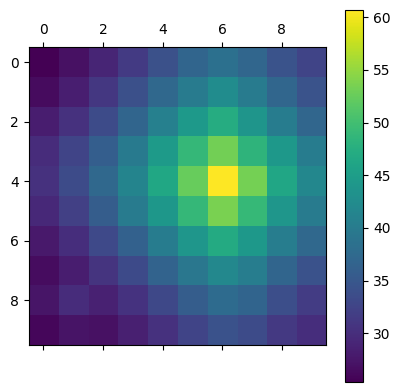

In [15]:
U = np.zeros(n_states + 1)  # Value function, U(s)
# U_updated = value_iteration(U, n_iters=100)
grid_display(U_updated)

In [16]:
# Extract optimal policy pi(s) = a from value function U(s)

def extract_policy(U, discount=0.95):
    policy = np.zeros(n_states+1)
    for s in range(1, n_states+1):
        max_action = 0
        max_action_value = -float('inf')
        for a in range(1, n_actions+1):
            later_rewards = sum([T[s, a, sp] * U[sp] for sp in range(1, n_states+1)])
            curr_action_value = R[s] + discount * later_rewards
            if curr_action_value > max_action_value:
                max_action = a
                max_action_value = curr_action_value
        policy[s] = max_action

    return policy

In [17]:
best_policy = extract_policy(U_updated)

In [18]:
best_policy

array([0., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 3., 3.,
       3., 3., 3., 1., 2., 2., 2., 2., 3., 3., 3., 3., 1., 1., 2., 2., 2.,
       2., 2., 2., 3., 3., 1., 1., 2., 2., 2., 2., 2., 2., 3., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 4., 1., 1., 1., 2., 2., 2., 4., 4., 4., 4.,
       4., 1., 1., 2., 4., 2., 4., 4., 4., 4., 4., 1., 1., 2., 2., 4., 2.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 1., 4.])

In [19]:
with open("small.policy", "w") as file:
    for a in best_policy[1:]:
        file.write(f"{int(a)}\n")